# Building Footprint: Rasters to Vectors

This notebook demonstrates the process of converting an output of the [Analytics Feed](https://developers.planet.com/docs/analytics/) (building footprint raster) into a vector dataset, using the following steps:

1. Obtaining An Analytics Raster
2. Downloading Quad Raster
3. Visualizing Buildings Image
4. Converting Buildings Raster to Vector Features using the following techniques:
    * GDAL CLI
    * [Rasterio](https://rasterio.readthedocs.io/en/stable/) (no processing)
    * Rasterio (with simplification)
    * Rasterio (flexible function, filtering and simplification as example)

Open this notebook in Colab below:

<a target="_blank" href="https://colab.research.google.com/github/planetlabs/notebooks/blob/master/jupyter-notebooks/analytics-snippets/raster_to_vector_buildingfootprints.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Import packages:

In [1]:
import json
import os
import requests
from pprint import pprint
from planet import Auth
from planet import Session, DataClient, OrdersClient
import fiona

import matplotlib.pyplot as plt
import rasterio
from rasterio import features as rfeatures
from rasterio.enums import Resampling
from rasterio.plot import show
import shapely
from shapely.geometry import shape as sshape
from shapely import affinity

## Set up API Key:

Ensure you have a Planet API Key which you can find [here](https://www.planet.com/account/#/user-settings).

In [2]:
# if your Planet API Key is not set as an environment variable, you can paste it below
API_KEY = os.environ.get('PL_API_KEY', 'PASTE_API_KEY_HERE')

client = Auth.from_key(API_KEY)

# Use our API key as the basic authentication username
apiAuth = (API_KEY, '')

## Working With Analytic Feed Results

**Results** on the Planet Analytics API represent the output or "detections" of our machine learning models. Results are created for each Subscription, and each Subscription is derived from a Feed:

*Feed → Subscription → Results* 

> When new Planet imagery is published that intersects a Subscription's AOI and TOI, Planet’s computer vision models process the imagery and the output is added to a "collection" (OGC API - Features) of Results associated with a Subscription.


#### Feed / Result Types

As we've seen, several types of **Feeds** exist, and Results for Feed Subscriptions can be categorized as one of three types: `Object Detection`, `Segmentation`, and `Change Detection`. This notebook covers the `Object Detection` and `Segmentation` feed types, while the next notebook covers `Change Detection` feeds.


#### Types of Feeds + Result Output Format

| Feed Type | Results Type | Results Format ||
| --- | --- | --- | --- |
| Vessel Detection | Object Detection | Detection Features (Polygons) |
| Building Detection | Segmentation (Classification) | Raster Mask / Basemaps |
| Road Detection | Segmentation (Classification) | Raster Mask / Basemaps |
| Building Construction Detection | Change Detection | Raster Mask / Basemaps |
| Road Construction Detection | Change Detection | Raster Mask / Basemaps |

We'll be working with Segmentation Feeds Results in this notebook.


## Obtain Analytics Raster

#### Identify Building Feed Feature for Download

We want to download the most recent feature from the feed for building detection in Sazgin, Turkey.

To do this, we need to:
1. List All Available Feed IDs
2. Identify the Feed ID we will need, corresponding to Building Detection
3. List Subscriptions with our selected Feed ID
4. Identify the Subscription ID we will need, corresponding to Sazgin, Turkey
5. Request the Results Collection corresponding to the Subscription ID we've identified
6. Find the most recent Feature from this Feature Collection


#### Setup the Request Endpoints

The request should go to the following address: https://api.planet.com/analytics/feeds

In [3]:
# Planet Analytics API base url
PAA_BASE_URL = "https://api.planet.com/analytics/"

In [4]:
# Define our endpoints to point to feeds, subscriptions, and collections
feeds_endpoint = 'feeds/'
subscriptions_endpoint = 'subscriptions/'
collections_endpoint = 'collections/'

# Construct the URL for the HTTP request 
# (Planet Analytics API base URL + desired endpoint)
feeds_request_url = PAA_BASE_URL + feeds_endpoint
subscriptions_request_url = PAA_BASE_URL + subscriptions_endpoint
collections_request_url = PAA_BASE_URL + collections_endpoint

#### List Available Feeds

Since we're making a `GET` request, we'll use Requests' `.get` method. Now, let's create our request by passing our request URL and auth variable. Running the next cell should make a call out to the Planet Analytics API.

If our request call is **successful** we should get back a response with a [`200 OK`](https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/200) `HTTP status code`! 

In [5]:
# Make the GET request
# A succesful request should return a 200 OK status code
feeds_response = requests.get(feeds_request_url, auth=apiAuth)

print(feeds_response)

<Response [200]>


In [6]:
# Read the Response Data
# Decode the response JSON body to a python dict
feeds_response_json = feeds_response.json()

In [7]:
# Get Feed IDs
for d in feeds_response_json['data']:
    print('{} ({}):\n\r{}\n\r'.format(d['id'], d['created'], d['description']))

5b73a193-484f-4aca-961b-2b1b21032a12 (2023-06-13T16:01:15.186Z):
Version semantics: v{source mosaic}.{G4 process}

6ca29572-1f8f-4d30-8935-1ed21e088c96 (2023-06-13T16:00:26.951Z):
Version semantics: v{source mosaic}.{G4 process}

c97c8c75-27c9-401d-a8b5-2bbc52612f42 (2023-06-07T19:02:42.012Z):
Version semantics: v{source mosaic}.{G4 process}

4088eddd-7aa6-4766-8be1-70d1a579de20 (2023-06-07T18:41:16.285Z):
Version semantics: v{source mosaic}.{G4 process}

6261fea4-dbd0-4399-b256-254c93eb2c95 (2023-06-07T18:38:14.382Z):
Version semantics: v{source mosaic}.{G4 process}

842b0912-45ca-4ef0-b100-1ef1685a74ef (2023-05-04T20:27:30.719Z):
Ship Detection TOA  -50m+

8573bae0-e718-42c5-af82-31bd7c3fbbc6 (2023-05-02T20:53:00.934Z):
Ship Detection TOA  - 25m+

b644c456-a67d-4ff0-9b34-b2c073193860 (2023-03-14T22:16:41.793Z):
Version semantics: v{source mosaic}.{G4 process}

fa5d9831-aa30-4507-96da-25cd6aacdf5a (2023-02-23T19:05:31.179Z):
Ship detections from rectified PlanetScope imagery

a069620d

#### Identify Feed ID We'll Use

We will use the following Feed_ID for Monthly Building Detection from the list above.

In [8]:
feed_id = 'b442c53b-fc72-4bee-bab4-0b7aa318ccd9'

#### List Subscriptions Containing Our Chosen Feed ID

In [9]:
# Set query parameters for the request
# Use the feedID`
feed_subscriptions_params = {"feedID": feed_id}

# Make the request to the api
feed_subscriptions_response = requests.get(subscriptions_request_url, params=feed_subscriptions_params, auth=apiAuth).json()

# Get the list of subscriptions from the 'data' property of the response
subscriptions = feed_subscriptions_response['data']

# Print the number of subscriptions found for the given feed
print("{} subscriptions found for Feed with id:\n{}\n".format(len(subscriptions), feed_id))

# Print the subscriptions list
print(json.dumps(subscriptions, indent=1))

20 subscriptions found for Feed with id:
b442c53b-fc72-4bee-bab4-0b7aa318ccd9

[
 {
  "created": "2021-09-24T21:35:19.713Z",
  "description": "Buildings Brazil",
  "endTime": "2022-09-23T00:00:00.000Z",
  "feedID": "b442c53b-fc72-4bee-bab4-0b7aa318ccd9",
  "geometry": {
   "type": "MultiPolygon",
   "coordinates": [
    [
     [
      [
       -38.6534611450606,
       -17.8765946006158
      ],
      [
       -38.7447614627392,
       -17.8787541724827
      ],
      [
       -38.7919641268185,
       -17.9180897258821
      ],
      [
       -38.8062795439138,
       -17.9593619571304
      ],
      [
       -38.7997236183472,
       -18.0065646212097
      ],
      [
       -38.7308037039576,
       -18.0702385341934
      ],
      [
       -38.6883326786126,
       -18.0745960624777
      ],
      [
       -38.6202888276032,
       -18.0391207084075
      ],
      [
       -38.5953661033792,
       -17.9500681465747
      ],
      [
       -38.6196230279755,
       -17.899587519712

In [10]:
# Get subscription ids
for d in subscriptions:
    print('{} ({}):\n\r{}\n\r'.format(d['id'], d['created'], d['title']))

eff2a2f1-f3b6-4a3f-b5ce-a619c474ab39 (2021-09-24T21:35:19.713Z):
PF Brazil Buildings_PL-0031008

4d830ca4-9284-4ca9-bb6b-0266db124f9f (2021-08-09T22:39:05.027Z):
Kinshasa Building Detection

04daedc2-ce71-4daa-98bb-2e5645dc58fc (2021-08-09T22:38:38.610Z):
Lagos Building Detection

167d03f6-0ce5-41a7-9fd7-b2c691852faf (2021-07-06T03:31:58.122Z):
Kuching - Building Detection 2017_Demo

dad0c54e-3f35-4006-b93c-0e5de4956f50 (2021-07-05T04:09:06.894Z):
Kuching - Building_Demo 2021

c7d19dcd-7044-4273-8614-29118316d3c5 (2021-05-18T22:37:49.099Z):
Lima, Peru

ebcf7209-9deb-4124-8c12-924fe1c21fe2 (2021-05-07T00:14:15.228Z):
Dubai - Buildings

296d6992-562e-4960-bc6d-e29e3a30fb4c (2021-04-16T18:32:36.270Z):
Syria

8cbf66c3-6188-41d2-8728-15010575abf1 (2021-02-24T14:53:45.030Z):
Skendata Building Detection

a30bd721-37f6-4090-9816-8683783f23a9 (2021-02-02T18:52:53.682Z):
Dhuba, Tabuk, Saudi Arabia

439bcb5d-cfb5-4d61-8698-0b922b40efeb (2020-09-17T02:32:38.848Z):
PF Brazil Buildings

20e908d2-61b

#### Identify the Subscription ID we will need, corresponding to Sazgin, Turkey

In [11]:
# building footprints in Sazgin, Turkey
subscription_id = '02c4f912-090f-45aa-a18b-ac4a55e4b9ba'

#### Request the Corresponding Results Collection

In [12]:
# First, we will request a subscription to look at the subscription details

# Construct the URL for the Subscription
subscription_url = PAA_BASE_URL + subscriptions_endpoint + subscription_id

print("Request URL: {}".format(subscription_url))

# Make the GET request for Subscriptions list 
subscription = requests.get(subscription_url, auth=apiAuth).json()

# Get subscription details
print("{} \n{}\nSubscription Id: {}\n".format(subscription['title'], subscription['description'], subscription['id']))

# Print the subscription object
print(json.dumps(subscription, sort_keys=True, indent=4))

Request URL: https://api.planet.com/analytics/subscriptions/02c4f912-090f-45aa-a18b-ac4a55e4b9ba
Sazgin, Turkey 
Monthly Building Detection
Subscription Id: 02c4f912-090f-45aa-a18b-ac4a55e4b9ba

{
    "created": "2019-11-07T23:15:29.078Z",
    "description": "Monthly Building Detection",
    "endTime": "2019-11-07T23:11:00.000Z",
    "feedID": "b442c53b-fc72-4bee-bab4-0b7aa318ccd9",
    "geometry": {
        "coordinates": [
            [
                [
                    37.30697658204,
                    36.8098985459143
                ],
                [
                    37.6802194098945,
                    36.8228121952488
                ],
                [
                    37.6279426523771,
                    37.1019963347993
                ],
                [
                    37.3230051224755,
                    37.1006048913409
                ],
                [
                    37.30697658204,
                    36.8098985459143
                ]
  

In [13]:
# Construct the URL for the subscription's Results Collection
collection_results_url = collections_request_url + subscription['id']

print("Request URL: {}".format(collection_results_url))

# Get subscription results collection
collection_results = requests.get(collection_results_url, auth=apiAuth).json()

# Pretty Print response JSON
print(json.dumps(collection_results, sort_keys=True, indent=4))

Request URL: https://api.planet.com/analytics/collections/02c4f912-090f-45aa-a18b-ac4a55e4b9ba
{
    "created": "2019-11-07T23:15:29.078Z",
    "description": "Monthly Building Detection",
    "extent": {
        "spatial": {
            "bbox": [
                [
                    37.30697658204,
                    36.8098985459143,
                    37.6802194098945,
                    37.1019963347993
                ]
            ]
        },
        "temporal": {
            "interval": [
                [
                    "2019-08-01T00:00:00.000Z",
                    "2019-11-07T23:11:00.000Z"
                ]
            ]
        }
    },
    "id": "02c4f912-090f-45aa-a18b-ac4a55e4b9ba",
    "links": [
        {
            "href": "https://api.planet.com/analytics/collections/02c4f912-090f-45aa-a18b-ac4a55e4b9ba",
            "rel": "self",
            "type": "application/json"
        },
        {
            "href": "https://api.planet.com/analytics/collections

In [14]:
# Request Collection Items
# What we got above was the collection itself. We're interested in the items in the collection

# Construct the URL for the subscription's Results Collection
collection_results_url = collections_request_url + subscription['id'] + '/' + 'items'

print("Request URL: {}".format(collection_results_url))

# Get subscription results collection
collection_items = requests.get(collection_results_url, auth=apiAuth).json()

# Pretty Print response JSON
print(json.dumps(collection_items, sort_keys=True, indent=4))

Request URL: https://api.planet.com/analytics/collections/02c4f912-090f-45aa-a18b-ac4a55e4b9ba/items
{
    "features": [
        {
            "created": "2019-12-03T21:37:51.724Z",
            "geometry": {
                "coordinates": [
                    [
                        [
                            37.4414062449,
                            36.73888412
                        ],
                        [
                            37.4414062449,
                            36.8796206007
                        ],
                        [
                            37.2656249949,
                            36.8796206007
                        ],
                        [
                            37.2656249949,
                            36.73888412
                        ],
                        [
                            37.4414062449,
                            36.73888412
                        ]
                    ]
                ],
             

In [15]:
# How many features do we have in this collection?

features = collection_items['features']
print('{} features in collection'.format(len(features)))

36 features in collection


#### Find the most recent Feature from this Feature Collection

In [16]:
# sort features by acquisition date and take latest feature

features.sort(key=lambda k: k['properties']['first_acquired'])
feature = features[-1]

print (feature)

print(feature['properties']['first_acquired'])

{'created': '2019-12-03T21:27:27.461Z', 'geometry': {'type': 'Polygon', 'coordinates': [[[37.6171874948, 37.020098197], [37.6171874948, 37.1603165423], [37.4414062449, 37.1603165423], [37.4414062449, 37.020098197], [37.6171874948, 37.020098197]]]}, 'id': '08b5f662-50e9-4779-aebc-fb110a9b5755', 'links': [{'href': 'https://api.planet.com/analytics/collections/02c4f912-090f-45aa-a18b-ac4a55e4b9ba/items/08b5f662-50e9-4779-aebc-fb110a9b5755', 'rel': 'self', 'type': 'application/geo+json'}, {'href': 'https://api.planet.com/analytics/collections/02c4f912-090f-45aa-a18b-ac4a55e4b9ba/items/08b5f662-50e9-4779-aebc-fb110a9b5755/resources/source-quad', 'rel': 'source-quad', 'type': 'image/tiff'}, {'href': 'https://tiles.planet.com/basemaps/v1/planet-tiles/global_monthly_2019_11_mosaic/gmap/{z}/{x}/{y}.png?api_key=PLAKc5a71489528f4bfe8fa087bfd60befc7', 'rel': 'source-tiles', 'type': 'image/png'}, {'href': 'https://api.planet.com/analytics/collections/02c4f912-090f-45aa-a18b-ac4a55e4b9ba/items/08b5f

## Download Quad Raster

Now that we've identified the feature in the feature collection that we're interested in, we can get this result using a "GET" request.

#### Downloading a Result Quad

If we want to download the raw quad data, for either the source or output target, we can do so via the Planet Mosaics API. To find the link to the file, we can look at the **Result** item's `links` property . Here's the first result from our Subscription Results collection:

In [17]:
feature_links = feature['links']
feature_links

[{'href': 'https://api.planet.com/analytics/collections/02c4f912-090f-45aa-a18b-ac4a55e4b9ba/items/08b5f662-50e9-4779-aebc-fb110a9b5755',
  'rel': 'self',
  'type': 'application/geo+json'},
 {'href': 'https://api.planet.com/analytics/collections/02c4f912-090f-45aa-a18b-ac4a55e4b9ba/items/08b5f662-50e9-4779-aebc-fb110a9b5755/resources/source-quad',
  'rel': 'source-quad',
  'type': 'image/tiff'},
 {'href': 'https://tiles.planet.com/basemaps/v1/planet-tiles/global_monthly_2019_11_mosaic/gmap/{z}/{x}/{y}.png?api_key=PLAKc5a71489528f4bfe8fa087bfd60befc7',
  'rel': 'source-tiles',
  'type': 'image/png'},
 {'href': 'https://api.planet.com/analytics/collections/02c4f912-090f-45aa-a18b-ac4a55e4b9ba/items/08b5f662-50e9-4779-aebc-fb110a9b5755/resources/target-quad',
  'rel': 'target-quad',
  'type': 'image/tiff'},
 {'href': 'https://tiles.planet.com/basemaps/v1/planet-tiles/sif-b442c53b-fc72-4bee-bab4-0b7aa318ccd9-2019-11-01/gmap/{z}/{x}/{y}.png?api_key=PLAKc5a71489528f4bfe8fa087bfd60befc7',
  '

Above, we see the links for both `target-quad` (the result output), and `source-quad` (the source imagery that was used to create the detections). We're interested in downloading the target (result) quad:

In [18]:
# Construct the URL to target quad
target_quad = list(filter(lambda link: link['rel'] == 'target-quad', feature_links))[0]['href']

print("Target (Result) Quad URL:\n{}\n".format(target_quad))

Target (Result) Quad URL:
https://api.planet.com/analytics/collections/02c4f912-090f-45aa-a18b-ac4a55e4b9ba/items/08b5f662-50e9-4779-aebc-fb110a9b5755/resources/target-quad



Clicking the link in the above cell will download the COG (.tiff) file!

## Visualize Buildings Image

The output of the analytics building detection is a boolean image where building pixels are given a value of True and non-building pixels are given a value of False.

In [19]:
# Set filepaths for target quad (raster), and folder where you'd like our vector files to be downloaded

filename = "/Users/em.steuer/Downloads/L15-1237E-1251N.tif"
dest = "/Users/em.steuer/"

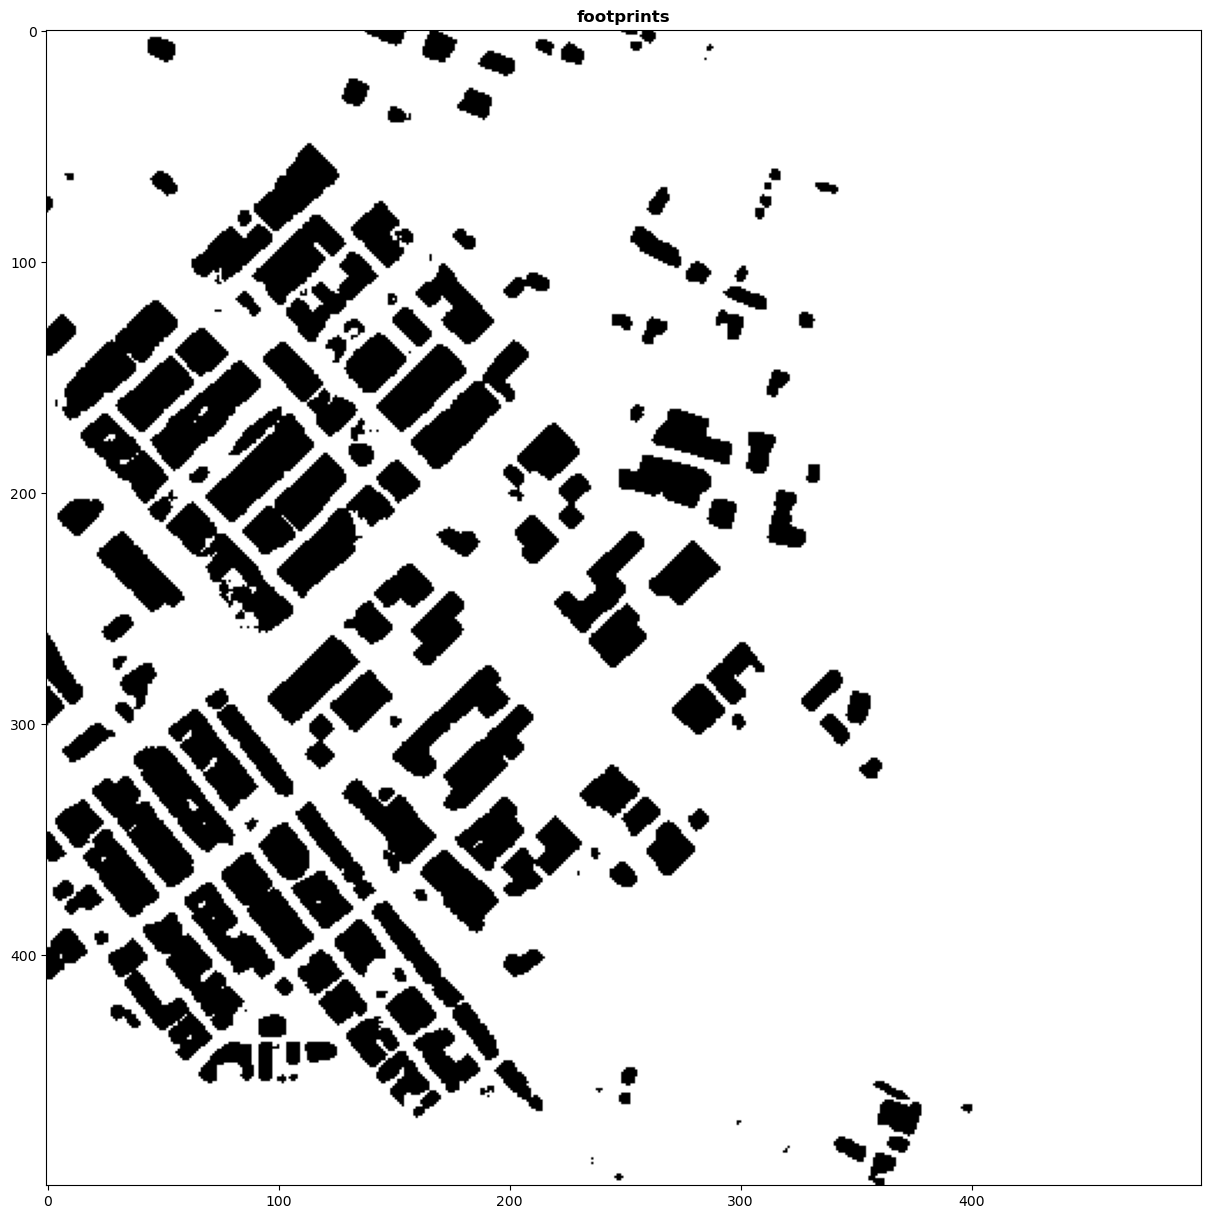

<AxesSubplot:title={'center':'footprints'}>

In [20]:
def _open(filename, factor=1):
    """
    Opens a raster file using rasterio and reads its data.

    Parameters:
        filename (str): The path to the raster file to be opened.
        factor (int, optional): A factor by which the height and width of the raster data will be reduced.
                                Default is 1, meaning no reduction.

    Returns:
        numpy.ndarray: A NumPy array containing the raster data after applying the reduction factor.
    """
    with rasterio.open(filename) as dataset:
        height = int(dataset.height / factor)
        width = int(dataset.width / factor)
        data = dataset.read(
            out_shape=(dataset.count, height, width)
        )
    return data

def open_bool(filename, factor=1):
    """
    Opens a raster file and returns its first band as a binary array. This function is a wrapper around the _open function, 
    which reads the raster file and applies any reduction factor specified. 
    The first band of the raster data is extracted, which is typically used to represent boolean data.

    Parameters:
        filename (str): The path to the raster file to be opened.
        factor (int, optional): A factor by which the height and width of the raster data will be reduced.
                                Default is 1, meaning no reduction.

    Returns:
        numpy.ndarray: A NumPy array containing the boolean raster data after applying the reduction factor.
                       The array represents the first band of the raster data.
    """
    data = _open(filename, factor=factor)
    return data[0,:,:]

def get_figsize(factor):
    """
    Calculates the figure size for plotting based on a given reduction factor. 
    The figure size is calculated as a tuple of two integers, representing the width and height of the figure.

    Parameters:
        factor (int): The reduction factor used for opening raster data.

    Returns:
        tuple: A tuple of two integers representing the width and height of the figure size.
    """
    return tuple(2 * [int(25/factor)])



factor = 1
figsize = (15, 15)

buildings = open_bool(filename, factor=factor)
fig = plt.figure(figsize=figsize)
# show(buildings, title="footprints", cmap="binary")
show(buildings[2500:3000, 0:500], title="footprints", cmap="binary")

## Convert Buildings Raster to Vector Features

Here, we examine several different ways to convert our buildings raster into vector features:
* GDAL CLI
* Rasterio (basic)
* Rasterio (simplified)
* Rasterio (flexible)


### GDAL Command-Line Interface (CLI)

GDAL provides a python script that can be run via the CLI. It is quite easy to run and fast.

In [21]:
def get_layer_name(filename):
    """
    This function derives the layer name from a given filename. The layer name 
    is considered as the part of the filename that comes before the first '.' character. 

    Note that the function assumes that the filename is provided in the form of a path, and that 
    the layer name does not contain any '.' characters.

    Args:
    filename (str): The path of the file from which to derive the layer name.

    Returns:
    str: The derived layer name.
    """
    return filename.split('/')[-1].split('.')[0]

gdal_tmp_output_filename = os.path.join(dest, 'test_gdal_all.shp')
gdal_tmp_output_layer_name = get_layer_name(gdal_tmp_output_filename)
gdal_output_filename = os.path.join(dest, 'test_gdal.shp')
gdal_output_layer_name = get_layer_name(gdal_output_filename)

In [22]:
# convert the binary image into polygons
# creates polygons for building footprints as well as regions between
# and around building footprints
!gdal_polygonize.py $filename $gdal_tmp_output_filename

0...10...20...30...40...50...60...70...80...90...100 - done.


In [23]:
# get number of features, this includes inside and outside building footprints
!ogrinfo -so  $gdal_tmp_output_filename $gdal_tmp_output_layer_name | grep 'Feature Count'

Feature Count: 4092


In [24]:
# get number of building footprint features
# building footprints are associated with image value (DN) of 255
!ogrinfo -so $gdal_tmp_output_filename -sql "SELECT * FROM $gdal_tmp_output_layer_name WHERE DN=255" \
    | grep 'Feature Count'

Feature Count: 3772


In [25]:
# create a new shapefile with only building footprints
!ogr2ogr -sql "SELECT * FROM $gdal_tmp_output_layer_name WHERE DN=255" \
    $gdal_output_filename $gdal_tmp_output_filename

In [26]:
# confirm the number of building footprint features
!ogrinfo -so $gdal_output_filename -sql "SELECT * FROM $gdal_output_layer_name WHERE DN=255" \
    | grep 'Feature Count'

Feature Count: 3772


### Rasterio

In this section we use rasterio to convert the binary buildings raster into a vector dataset. The vectors are written to disk as a shapefile. The shapefile can be imported into geospatial programs such as QGIS or ArcGIS for visualization and further processing.

This is basic conversion to vector shapes. No smoothing to remove pixel edges, or conversion to the building centerlines is performed here.

In [27]:
def buildings_as_vectors(filename): 
    """
    This function reads building data from a raster file, applies a mask to non-building pixels, 
    and transforms the building data into image CRS (Coordinate Reference System) using the transformation information 
    from the raster file.

    Args:
    filename (str): The path of the raster file to read the data from.

    Returns:
    tuple: A tuple containing the transformed building geometries and the CRS of the dataset.
    """
    with rasterio.open(filename) as dataset:
        buildings = dataset.read(1)
        building_mask = buildings == 255 # mask non-building pixels

        # transforms buildings features to image crs
        building_shapes = rfeatures.shapes(buildings, mask=building_mask, transform=dataset.transform)
        building_geometries = (s for s, _ in building_shapes)
        
        crs = dataset.crs
    return (building_geometries, crs)

def save_as_shapefile(output_filename, geometries, crs):
    """
    This function saves the provided geometries into a shapefile.

    Args:
    output_filename (str): The path of the output shapefile.
    geometries (iterable): The geometries to write into the shapefile.
    crs (CRS): The Coordinate Reference System to use for the shapefile.

    """
    driver='ESRI Shapefile'
    schema = {'geometry': 'Polygon', 'properties': []}
    with fiona.open(output_filename, mode='w', driver=driver, schema=schema, crs=crs) as c:
        count = 0
        for g in geometries:
            count += 1;
            c.write({'geometry': g, 'properties': {}})
        print('wrote {} geometries to {}'.format(count, output_filename))

        
building_geometries, crs = buildings_as_vectors(filename)
output_filename = os.path.join(dest, 'test_rasterio.shp')
save_as_shapefile(output_filename, building_geometries, crs)

wrote 3772 geometries to /Users/em.steuer/test_rasterio.shp


### Rasterio - Simplifying

In this section, we use `shapely` to simplify the building footprints so we don't have a million pixel edges.

In [30]:
def buildings_as_vectors_with_simplification(filename): 
    """
    This function reads building data from a raster file, applies a mask to non-building pixels,
    simplifies the geometries in the pixel space, and then transforms them to image CRS (Coordinate Reference System). 
    During the simplification process, it skips the transform operation on vectorization and applies 
    a simplification tolerance to avoid too many pixel edge points. It then transforms the simplified shapes 
    to the CRS of the dataset. 

    Args:
    filename (str): The path of the raster file to read the data from.

    Returns:
    tuple: A tuple containing the simplified and transformed building geometries and the CRS of the dataset.
    """
    with rasterio.open(filename) as dataset:
        buildings = dataset.read(1)
        building_mask = buildings == 255 # mask non-building pixels

        # we skip transform on vectorization so we can perform filtering in pixel space
        building_shapes = rfeatures.shapes(buildings, mask=building_mask)
        building_geometries = (s for s, _ in building_shapes)
        geo_shapes = (sshape(g) for g in building_geometries)
    
        # simplify so we don't have a million pixel edge points
        # value of 1 (in units of pixels) determined by visual comparison to non-simplified
        tolerance = 1
        geo_shapes = (g.simplify(tolerance, preserve_topology=False)
                      for g in geo_shapes)

        # apply image transform    
        # rasterio transform: (a, b, c, d, e, f, 0, 0, 1), c and f are offsets
        # shapely: a b d e c/xoff f/yoff
        d = dataset.transform
        shapely_transform = [d[0], d[1], d[3], d[4], d[2], d[5]]
        proj_shapes = (shapely.affinity.affine_transform(g, shapely_transform)
                       for g in geo_shapes)
        
        building_geometries = (shapely.geometry.mapping(s) for s in proj_shapes)
        
        crs = dataset.crs
    return (building_geometries, crs)

building_geometries_simp, crs = buildings_as_vectors_with_simplification(filename)
output_filename = os.path.join(dest, 'test_rasterio_simp.shp')
save_as_shapefile(output_filename, building_geometries_simp, crs)

wrote 3772 geometries to /Users/em.steuer/test_rasterio_simp.shp


### Appendix - Extending the Calculation with Rasterio

In this section we get a little bit fancy and set up the rasterio vectorization function so that it can take any calculation function, as long as that function has a generator of `rasterio.shape` as input and a generator of `rasterio.shape` as output. We will use this to filter and simplify building footprint shapes.

In [31]:
def buildings_as_vectors_proc(filename, proc_fcn): 
    """
    This function reads building data from a raster file, applies a mask to non-building pixels, 
    applies an arbitrary processing function to the geometries, and then transforms them to image 
    CRS (Coordinate Reference System). The function allows for additional processing flexibility 
    with the help of proc_fcn which can be any function that takes in a generator of shapely
    geometry and returns a similar generator of processed shapely geometry.

    Args:
    filename (str): The path of the raster file to read the data from.
    proc_fcn (function): The processing function to apply to the geometries.

    Returns:
    tuple: A tuple containing the processed and transformed building geometries and the CRS of the dataset.
    """
    with rasterio.open(filename) as dataset:
        buildings = dataset.read(1)
        building_mask = buildings == 255 # mask non-building pixels

        # we skip transform on vectorization so we can perform filtering in pixel space
        building_shapes = rfeatures.shapes(buildings, mask=building_mask)
        building_geometries = (s for s, _ in building_shapes)
        geo_shapes = (sshape(g) for g in building_geometries)
        
        # apply arbitrary processing function
        geo_shapes = proc_fcn(geo_shapes)

        # apply image transform    
        # rasterio transform: (a, b, c, d, e, f, 0, 0, 1), c and f are offsets
        # shapely: a b d e c/xoff f/yoff
        d = dataset.transform
        shapely_transform = [d[0], d[1], d[3], d[4], d[2], d[5]]
        proj_shapes = (shapely.affinity.affine_transform(g, shapely_transform)
                       for g in geo_shapes)
        
        building_geometries = (shapely.geometry.mapping(s) for s in proj_shapes)
        
        crs = dataset.crs
    return (building_geometries, crs)

def filter_and_simplify_footprints(footprints):
    """
    This function filters and simplifies the provided footprints. The function applies two steps of processing:
    - It filters out footprints that consist of less than 6 pixels.
    - It simplifies the footprints to reduce pixel edge points.

    Args:
    footprints (iterable): The footprints to filter and simplify.

    Returns:
    iterable: A generator of the filtered and simplified footprints.
    """
    # filter to shapes consisting of 6 or more pixels
    min_pixel_size = 6
    geo_shapes = (s for s in footprints if s.area >= min_pixel_size)
        
    # simplify so we don't have a million pixel edge points
    # value of 1 (in units of pixels) determined by visual comparison to non-simplified
    tolerance = 1
    geo_shapes = (s.simplify(tolerance, preserve_topology=False)
                  for s in geo_shapes)
    return geo_shapes

building_geometries_simp, crs = buildings_as_vectors_proc(filename, filter_and_simplify_footprints)
output_filename = os.path.join(dest, 'test_rasterio_proc.shp')
save_as_shapefile(output_filename, building_geometries_simp, crs)

wrote 3437 geometries to /Users/em.steuer/test_rasterio_proc.shp
